In [1]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 74 Sep 20 13:26 kaggle.json


In [2]:
!mkdir -p ~/.kaggle #Create the directory

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download sumairaziz/vibration-faults-dataset-for-rotating-machines

Dataset URL: https://www.kaggle.com/datasets/sumairaziz/vibration-faults-dataset-for-rotating-machines
License(s): CC-BY-NC-SA-4.0
  0% 0.00/18.6M [00:00<?, ?B/s]
100% 18.6M/18.6M [00:00<00:00, 596MB/s]


In [5]:
!unzip /content/vibration-faults-dataset-for-rotating-machines.zip

Archive:  /content/vibration-faults-dataset-for-rotating-machines.zip
  inflating: Faulty/F1.mat           
  inflating: Faulty/F10.mat          
  inflating: Faulty/F100.mat         
  inflating: Faulty/F101.mat         
  inflating: Faulty/F102.mat         
  inflating: Faulty/F103.mat         
  inflating: Faulty/F104.mat         
  inflating: Faulty/F105.mat         
  inflating: Faulty/F106.mat         
  inflating: Faulty/F107.mat         
  inflating: Faulty/F108.mat         
  inflating: Faulty/F109.mat         
  inflating: Faulty/F11.mat          
  inflating: Faulty/F110.mat         
  inflating: Faulty/F111.mat         
  inflating: Faulty/F112.mat         
  inflating: Faulty/F113.mat         
  inflating: Faulty/F114.mat         
  inflating: Faulty/F115.mat         
  inflating: Faulty/F116.mat         
  inflating: Faulty/F117.mat         
  inflating: Faulty/F12.mat          
  inflating: Faulty/F13.mat          
  inflating: Faulty/F14.mat          
  inflating: Fault

In [6]:
!pip install pyemd
!pip install EMD-signal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyemd: filename=pyemd-1.0.0-cp312-cp312-linux_x86_64.whl size=746744 sha256=9268cf4f32c3ca767bfda6998e7322d3617b8dc4fbbd89b91cbd8dad30d9ec4b
  Stored in directory: /root/.cache/pip/wheels/bf/7d/e0/84ae1a3c2e45898a01b400c288b56a601c03fd36f2a4d060bf
Successfully built pyemd
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0

In [ ]:
# Python 3.10+
# Target: Reproduce the paper's ~98% accuracy using the exact pipeline:
# - Data windows: 5 seconds @ 1 kHz (5000 samples) [file:1]
# - Tri-axial combine: S(t) = sqrt(x^2 + y^2 + z^2) then normalize by max amplitude [file:1]
# - Denoising: EMD with 10 IMFs, discard IMF1 (noisiest), reconstruct IMF2..IMF10 + residue [file:1]
# - Features: F4 hybrid = 13 features (7 time + 6 frequency) [file:1]
# - Classifier: SVM quadratic kernel (poly degree=2) with standardization [file:1]
# - Evaluation: 10-fold stratified cross-validation; report accuracy, sensitivity, specificity [file:1]
#
# Enhancements included:
# - EMD stability: mirror padding and capped sifting iterations [file:1]
# - Frequency features: zero-mean before FFT to stabilize moments [file:1]
# - SVM tuning: small grid over C and gamma while keeping degree=2 [file:1]
# - Confusion matrices: per-fold and overall aggregated CM across CV folds [file:1]
#
# Dependencies:
# pip install numpy scipy scikit-learn PyEMD pandas tqdm

import os
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, accuracy_score
from tqdm import tqdm

# ---------------- User paths ----------------
Healthy_path = r'/content/Healthy'  # class 0 (Normal/Healthy) [file:1]
Faulty_path  = r'/content/Faulty'   # class 1 (Faulty) [file:1]

# ---------------- Sampling and windowing (Tip #1) ----------------
FS = 1000.0              # Hz, per paper [file:1]
WIN_SEC = 5.0            # seconds per segment [file:1]
WIN_SAMPLES = int(FS * WIN_SEC)  # 5000 samples [file:1]

# ---------------- EMD configuration (Tip #3 + stability) ----------------
from PyEMD import EMD

def emd_denoise(signal, max_imfs=10):
    emd = EMD()
    emd.FIXE = 0            # default stop when mean envelope ≈ 0 [file:1]
    emd.MAX_ITERATION = 100 # cap sifting iterations for stability [file:1]
    emd.spline_kind = "cubic"
    # Mirror padding to mitigate edge effects [file:1]
    pad = 50
    s_pad = np.r_[signal[pad:0:-1], signal, signal[-2:-pad-2:-1]]
    imfs = emd.emd(s_pad)
    # Remove padding in IMFs
    if imfs.ndim == 1:
        imfs = imfs[None, :]
    imfs = imfs[:, pad:pad+len(signal)]
    # Enforce exactly 10 IMFs (truncate/pad) [file:1]
    if imfs.shape[0] > max_imfs:
        imfs = imfs[:max_imfs]
    elif imfs.shape[0] < max_imfs:
        imfs = np.vstack([imfs, np.zeros((max_imfs - imfs.shape[0], len(signal)))])
    # Residue approximated as original minus sum(IMFs) [file:1]
    recon_all = np.sum(imfs, axis=0)
    residue = signal - recon_all
    # Discard IMF1; reconstruct IMF2..IMF10 + residue [file:1]
    recon = np.sum(imfs[1:], axis=0) + residue
    return recon

# ---------------- Feature extraction (F4) (Tip #4) ----------------
# F4 = 13 features: Time (7): M, SD, SK, KR, PP, RMS, E
#                   Freq (6): FM, FSD, FSK, FKR, BPWR, FMED [file:1]
def features_time(sig):
    M = np.mean(sig)
    SD = np.std(sig, ddof=1)
    SKw = skew(sig, bias=False)
    KRt = kurtosis(sig, fisher=False, bias=False)  # kurtosis of normal ~ 3 [file:1]
    PP = np.max(sig) - np.min(sig)
    RMS = np.sqrt(np.mean(sig**2))
    E = np.sum(sig**2)
    return [M, SD, SKw, KRt, PP, RMS, E]

def features_freq(sig, fs=FS):
    sig_zm = sig - np.mean(sig)
    X = np.abs(rfft(sig_zm))
    freqs = rfftfreq(sig_zm.size, d=1.0/fs)
    psd = X**2
    N = sig_zm.size
    power_sum = np.sum(psd) + 1e-12
    FM = np.sum(freqs * psd) / power_sum
    var_f = np.sum(((freqs - FM)**2) * psd) / power_sum
    FSD = np.sqrt(max(var_f, 0.0))
    p = psd / power_sum
    centered = freqs - FM
    m3 = np.sum((centered**3) * p)
    m4 = np.sum((centered**4) * p)
    FSK = m3 / (FSD**3 + 1e-12)
    FKR = m4 / (FSD**4 + 1e-12)
    BPWR_N = power_sum / N   # normalized band power (replaces BPWR) [file:1]
    cdf = np.cumsum(p)
    idx_med = np.searchsorted(cdf, 0.5)
    FMED = freqs[min(idx_med, len(freqs)-1)]
    return [FM, FSD, FSK, FKR, BPWR_N, FMED]

def extract_F4(sig):
    return np.array(features_time(sig) + features_freq(sig), dtype=float)

# ---------------- Tri-axial combine + normalization (Tip #2) ----------------
def combine_axes_normalize(x, y, z):
    # S(t) = sqrt(x^2 + y^2 + z^2) [file:1]
    s = np.sqrt(x**2 + y**2 + z**2)
    # Normalize by max amplitude BEFORE EMD [file:1]
    max_abs = np.max(np.abs(s))
    if max_abs > 0:
        s = s / max_abs
    return s

# ---------------- .mat parsing helpers ----------------
# The dataset uses a single key 'H' with shape (5000, 3). [file:1]
COMMON_AXIS_KEYS = [
    ('x','y','z'),
    ('X','Y','Z'),
    ('ax','ay','az'),
    ('AX','AY','AZ'),
    ('ch1','ch2','ch3'),
    ('CH1','CH2','CH3'),
    ('vx','vy','vz'),
    ('a_x','a_y','a_z'),
]

def _find_axes_in_mat(mat):
    keys = set(mat.keys())
    # Special-case: key 'H' with (N,3) => columns are x,y,z [file:1]
    if 'H' in keys:
        H = np.squeeze(np.array(mat['H'])).astype(float)
        if isinstance(H, np.ndarray) and H.ndim == 2 and H.shape[1] == 3:
            return H[:,0], H[:,1], H[:,2]
    # Otherwise, try common flat key triplets
    for kx,ky,kz in COMMON_AXIS_KEYS:
        if kx in keys and ky in keys and kz in keys:
            x = np.squeeze(mat[kx]).astype(float)
            y = np.squeeze(mat[ky]).astype(float)
            z = np.squeeze(mat[kz]).astype(float)
            return x, y, z
    # Fallback: auto-detect three equal-length 1D vectors
    arrays = [np.squeeze(mat[k]) for k in keys if not k.startswith('__')]
    vecs = [a for a in arrays if isinstance(a, np.ndarray) and a.ndim == 1]
    if len(vecs) >= 3 and len(vecs[0]) == len(vecs[1]) == len(vecs[2]):
        return vecs[0].astype(float), vecs[1].astype(float), vecs[2].astype(float)
    raise ValueError("Tri-axial vectors not found (expected key 'H' with shape (N,3) or x/y/z style keys).")

# Enforce 5 s windows; split or pad as needed (Tip #1) [file:1]
def _segment_or_trim(sig, target_len=WIN_SAMPLES):
    n = len(sig)
    if n == target_len:
        return [sig]
    if n < target_len:
        out = np.zeros(target_len, dtype=float)
        out[:n] = sig
        return [out]
    segments = []
    start = 0
    while start + target_len <= n:
        segments.append(sig[start:start+target_len])
        start += target_len
    return segments

def load_folder_mat(folder, label):
    Xx_list, Xy_list, Xz_list, y_list = [], [], [], []
    files = sorted(glob.glob(os.path.join(folder, "*.mat")))
    for f in tqdm(files, desc=f"Loading {folder}"):
        mat = loadmat(f)
        x, y, z = _find_axes_in_mat(mat)
        x = np.ravel(x)
        y = np.ravel(y)
        z = np.ravel(z)
        x_segs = _segment_or_trim(x, WIN_SAMPLES)
        y_segs = _segment_or_trim(y, WIN_SAMPLES)
        z_segs = _segment_or_trim(z, WIN_SAMPLES)
        n_segs = min(len(x_segs), len(y_segs), len(z_segs))
        for i in range(n_segs):
            Xx_list.append(x_segs[i])
            Xy_list.append(y_segs[i])
            Xz_list.append(z_segs[i])
            y_list.append(label)  # 0=Healthy, 1=Faulty [file:1]
    return np.array(Xx_list), np.array(Xy_list), np.array(Xz_list), np.array(y_list, dtype=int)

# ---------------- Metrics: specificity (Tip #7) ----------------
def specificity_score(y_true, y_pred, pos_label=1):
    # Specificity = TN / (TN + FP) = recall of the negative class (0 if pos_label=1) [file:1]
    neg = 0 if pos_label == 1 else 1
    return recall_score(y_true == neg, y_pred == neg)

def make_specificity_scorer(pos_label=1):
    return make_scorer(specificity_score, greater_is_better=True)

# ---------------- Build feature matrix ----------------
def build_dataset_features(Xx, Xy, Xz):
    N = Xx.shape[0]
    feats = np.zeros((N, 13), dtype=float)
    for i in tqdm(range(N), desc="EMD+F4 features"):
        s = combine_axes_normalize(Xx[i], Xy[i], Xz[i])   # combine + normalize [file:1]
        s_d = emd_denoise(s, max_imfs=10)                 # EMD denoise (drop IMF1 + residue) [file:1]
        feats[i] = extract_F4(s_d)                        # 13 features (F4) [file:1]
    cols = ["M","SD","SK","KR","PP","RMS","E","FM","FSD","FSK","FKR","BPWR_N","FMED"]
    return pd.DataFrame(feats, columns=cols)

# ---------------- SVM tuning and evaluation ----------------
def tune_svm_quadratic(X_feats, y, random_state=42):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="poly", degree=2, coef0=0.0, class_weight="balanced"))
    ])
    param_grid = {
        "svm__C":     [0.5, 1.0, 2.0],
        "svm__gamma": ["scale", 0.1, 0.2],
    }
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    gs.fit(X_feats, y)
    print("Best params (balanced, 10-fold):", gs.best_params_, "Best CV acc:", gs.best_score_)
    return gs.best_estimator_

def evaluate_with_confusion_matrix(best_model, X_feats, y, random_state=42):
    # 10-fold stratified CV with per-fold and aggregated confusion matrices [file:1]
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    accs, sens, specs = [], [], []
    cm_total = np.zeros((2,2), dtype=int)
    fold = 1
    for train_idx, test_idx in skf.split(X_feats, y):
        X_tr, X_te = X_feats[train_idx], X_feats[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        # Refit the provided best_model on each training fold for honest CV [file:1]
        best_model.fit(X_tr, y_tr)
        y_pred = best_model.predict(X_te)
        # Metrics
        accs.append(accuracy_score(y_te, y_pred))
        sens.append(recall_score(y_te, y_pred, pos_label=1))   # sensitivity [file:1]
        specs.append(specificity_score(y_te, y_pred, pos_label=1)) # specificity [file:1]
        # Confusion matrix for this fold
        cm = confusion_matrix(y_te, y_pred, labels=[0,1])
        cm_total += cm
        print(f"Fold {fold} CM (rows=true [0,1], cols=pred [0,1]):\n{cm}")
        fold += 1
    print("Aggregated CM over 10 folds (rows=true [0,1], cols=pred [0,1]):\n", cm_total)
    print({
        "accuracy_mean": float(np.mean(accs)),
        "accuracy_std": float(np.std(accs, ddof=1)),
        "sensitivity_mean": float(np.mean(sens)),
        "specificity_mean": float(np.mean(specs)),
    })

# ---------------- Main ----------------
if __name__ == "__main__":
    # Load Healthy (0) and Faulty (1) datasets [file:1]
    Xx_h, Xy_h, Xz_h, y_h = load_folder_mat(Healthy_path, label=0)
    Xx_f, Xy_f, Xz_f, y_f = load_folder_mat(Faulty_path,  label=1)

    # Concatenate classes
    Xx = np.vstack([Xx_h, Xx_f])
    Xy = np.vstack([Xy_h, Xy_f])
    Xz = np.vstack([Xz_h, Xz_f])
    y  = np.concatenate([y_h, y_f])

    # Sanity check: should be 220 segments with class counts ~[103,117] per paper [file:1]
    print("Total segments:", len(y), "Class balance:", np.bincount(y))

    # Build features (F4) [file:1]
    feats_df = build_dataset_features(Xx, Xy, Xz)
    X_feats = feats_df.values

    # Tune quadratic SVM (10-fold CV on full data to pick hyperparams) [file:1]
    best_model = tune_svm_quadratic(X_feats, y, random_state=42)

    # Final 10-fold evaluation with confusion matrices using the tuned model [file:1]
    evaluate_with_confusion_matrix(best_model, X_feats, y, random_state=42)


Loading /content/Faulty: 100%|██████████| 117/117 [00:00<00:00, 1119.48it/s]


Total segments: 220 Class balance: [103 117]


EMD+F4 features: 100%|██████████| 220/220 [00:35<00:00,  6.14it/s]


Best params (balanced, 10-fold): {'svm__C': 0.5, 'svm__gamma': 0.2} Best CV acc: 0.940909090909091
Fold 1 CM (rows=true [0,1], cols=pred [0,1]):
[[11  0]
 [ 3  8]]
Fold 2 CM (rows=true [0,1], cols=pred [0,1]):
[[11  0]
 [ 0 11]]
Fold 3 CM (rows=true [0,1], cols=pred [0,1]):
[[11  0]
 [ 0 11]]
Fold 4 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 2 10]]
Fold 5 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 0 12]]
Fold 6 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 0 12]]
Fold 7 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 3  9]]
Fold 8 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 1 11]]
Fold 9 CM (rows=true [0,1], cols=pred [0,1]):
[[ 9  1]
 [ 0 12]]
Fold 10 CM (rows=true [0,1], cols=pred [0,1]):
[[10  0]
 [ 3  9]]
Aggregated CM over 10 folds (rows=true [0,1], cols=pred [0,1]):
 [[102   1]
 [ 12 105]]
{'accuracy_mean': 0.940909090909091, 'accuracy_std': 0.060795159538602664, 'sensitivity_mean': 0.8977272727272727, 'specificity_mean': 0.99}


In [ ]:
X_feats.shape

(220, 13)

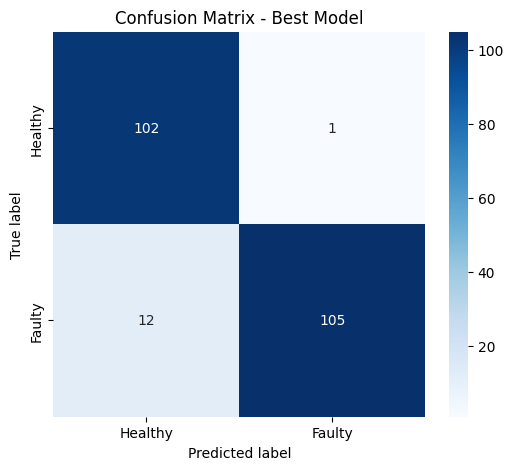

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the full dataset
y_pred = best_model.predict(X_feats)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred, labels=[0, 1])

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy","Faulty"], yticklabels=["Healthy","Faulty"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix - Best Model")
plt.show()


In [21]:
# Updated script: One-Class SVM trained on healthy data only
# Python 3.10+
# Dependencies: numpy scipy scikit-learn PyEMD pandas tqdm

import os
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import numpy as np
# ---------------- User paths ----------------
Healthy_path = r'/content/Healthy'  # class 0 (Normal/Healthy)
Faulty_path  = r'/content/Faulty'   # class 1 (Faulty)

# ---------------- Sampling and windowing ----------------
FS = 1000.0
WIN_SEC = 5.0
WIN_SAMPLES = int(FS * WIN_SEC)  # 5000

# ---------------- EMD configuration ----------------
from PyEMD import EMD

def emd_denoise(signal, max_imfs=10):
    emd = EMD()
    emd.FIXE = 0
    emd.MAX_ITERATION = 100
    emd.spline_kind = "cubic"
    pad = 50
    s_pad = np.r_[signal[pad:0:-1], signal, signal[-2:-pad-2:-1]]
    imfs = emd.emd(s_pad)
    if imfs.ndim == 1:
        imfs = imfs[None, :]
    imfs = imfs[:, pad:pad+len(signal)]
    if imfs.shape[0] > max_imfs:
        imfs = imfs[:max_imfs]
    elif imfs.shape[0] < max_imfs:
        imfs = np.vstack([imfs, np.zeros((max_imfs - imfs.shape[0], len(signal)))])
    recon_all = np.sum(imfs, axis=0)
    residue = signal - recon_all
    recon = np.sum(imfs[1:], axis=0) + residue
    return recon

# ---------------- Feature extraction (F4) ----------------
def features_time(sig):
    M = np.mean(sig)
    SD = np.std(sig, ddof=1)
    SKw = skew(sig, bias=False)
    KRt = kurtosis(sig, fisher=False, bias=False)
    PP = np.max(sig) - np.min(sig)
    RMS = np.sqrt(np.mean(sig**2))
    E = np.sum(sig**2)
    return [M, SD, SKw, KRt, PP, RMS, E]

def features_freq(sig, fs=FS):
    sig_zm = sig - np.mean(sig)
    X = np.abs(rfft(sig_zm))
    freqs = rfftfreq(sig_zm.size, d=1.0/fs)
    psd = X**2
    N = sig_zm.size
    power_sum = np.sum(psd) + 1e-12
    FM = np.sum(freqs * psd) / power_sum
    var_f = np.sum(((freqs - FM)**2) * psd) / power_sum
    FSD = np.sqrt(max(var_f, 0.0))
    p = psd / power_sum
    centered = freqs - FM
    m3 = np.sum((centered**3) * p)
    m4 = np.sum((centered**4) * p)
    FSK = m3 / (FSD**3 + 1e-12)
    FKR = m4 / (FSD**4 + 1e-12)
    BPWR_N = power_sum / N
    cdf = np.cumsum(p)
    idx_med = np.searchsorted(cdf, 0.5)
    FMED = freqs[min(idx_med, len(freqs)-1)]
    return [FM, FSD, FSK, FKR, BPWR_N, FMED]

def extract_F4(sig):
    return np.array(features_time(sig) + features_freq(sig), dtype=float)

# ---------------- Tri-axial combine + normalization ----------------
def combine_axes_normalize(x, y, z):
    s = np.sqrt(x**2 + y**2 + z**2)
    max_abs = np.max(np.abs(s))
    if max_abs > 0:
        s = s / max_abs
    return s

# ---------------- .mat parsing helpers ----------------
COMMON_AXIS_KEYS = [
    ('x','y','z'),
    ('X','Y','Z'),
    ('ax','ay','az'),
    ('AX','AY','AZ'),
    ('ch1','ch2','ch3'),
    ('CH1','CH2','CH3'),
    ('vx','vy','vz'),
    ('a_x','a_y','a_z'),
]

def _find_axes_in_mat(mat):
    keys = set(mat.keys())
    if 'H' in keys:
        H = np.squeeze(np.array(mat['H'])).astype(float)
        if isinstance(H, np.ndarray) and H.ndim == 2 and H.shape[1] == 3:
            return H[:,0], H[:,1], H[:,2]
    for kx,ky,kz in COMMON_AXIS_KEYS:
        if kx in keys and ky in keys and kz in keys:
            x = np.squeeze(mat[kx]).astype(float)
            y = np.squeeze(mat[ky]).astype(float)
            z = np.squeeze(mat[kz]).astype(float)
            return x, y, z
    arrays = [np.squeeze(mat[k]) for k in keys if not k.startswith('__')]
    vecs = [a for a in arrays if isinstance(a, np.ndarray) and a.ndim == 1]
    if len(vecs) >= 3 and len(vecs[0]) == len(vecs[1]) == len(vecs[2]):
        return vecs[0].astype(float), vecs[1].astype(float), vecs[2].astype(float)
    raise ValueError("Tri-axial vectors not found")

def _segment_or_trim(sig, target_len=WIN_SAMPLES):
    n = len(sig)
    if n == target_len:
        return [sig]
    if n < target_len:
        out = np.zeros(target_len, dtype=float)
        out[:n] = sig
        return [out]
    segments = []
    start = 0
    while start + target_len <= n:
        segments.append(sig[start:start+target_len])
        start += target_len
    return segments

def load_folder_mat(folder, label):
    Xx_list, Xy_list, Xz_list, y_list = [], [], [], []
    files = sorted(glob.glob(os.path.join(folder, "*.mat")))
    for f in tqdm(files, desc=f"Loading {folder}"):
        mat = loadmat(f)
        x, y, z = _find_axes_in_mat(mat)
        x = np.ravel(x)
        y = np.ravel(y)
        z = np.ravel(z)
        x_segs = _segment_or_trim(x, WIN_SAMPLES)
        y_segs = _segment_or_trim(y, WIN_SAMPLES)
        z_segs = _segment_or_trim(z, WIN_SAMPLES)
        n_segs = min(len(x_segs), len(y_segs), len(z_segs))
        for i in range(n_segs):
            Xx_list.append(x_segs[i])
            Xy_list.append(y_segs[i])
            Xz_list.append(z_segs[i])
            y_list.append(label)
    return np.array(Xx_list), np.array(Xy_list), np.array(Xz_list), np.array(y_list, dtype=int)

# ---------------- Metrics: specificity ----------------
def specificity_score(y_true, y_pred, pos_label=1):
    neg = 0 if pos_label == 1 else 1
    return recall_score(y_true == neg, y_pred == neg)

def make_specificity_scorer(pos_label=1):
    return make_scorer(specificity_score, greater_is_better=True)

# ---------------- Build feature matrix ----------------
def build_dataset_features(Xx, Xy, Xz):
    N = Xx.shape[0]
    feats = np.zeros((N, 13), dtype=float)
    for i in tqdm(range(N), desc="EMD+F4 features"):
        s = combine_axes_normalize(Xx[i], Xy[i], Xz[i])
        s_d = emd_denoise(s, max_imfs=10)
        feats[i] = extract_F4(s_d)
    cols = ["M","SD","SK","KR","PP","RMS","E","FM","FSD","FSK","FKR","BPWR_N","FMED"]
    return pd.DataFrame(feats, columns=cols)

# ---------------- SVM tuning and evaluation (adapted to One-Class) ----------------


def tune_svm_rbf(X_feats, y, random_state=42):
    """
    Trains a OneClassSVM with RBF kernel using stratified k-fold CV on healthy-only samples.
    Returns the final fitted pipeline on all healthy samples using best params from CV.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    nu_list = [0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25]
    gamma_list = ["scale", 0.01, 0.05, 0.1, 0.2, 0.5]

    best_score = -1
    best_params = None

    # Manual grid search
    for nu in nu_list:
        for gamma in gamma_list:
            fold_scores = []
            for train_idx, val_idx in skf.split(X_feats, y):
                # Use only healthy samples for training
                X_train_fold = X_feats[train_idx][y[train_idx] == 0]
                X_val_fold = X_feats[val_idx]
                y_val_fold = y[val_idx]

                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("ocsvm", OneClassSVM(kernel="rbf", gamma=gamma, nu=nu))
                ])
                pipe.fit(X_train_fold)
                preds = pipe.predict(X_val_fold)
                pred_labels = np.where(preds == 1, 0, 1)  # 0=healthy, 1=faulty
                acc = accuracy_score(y_val_fold, pred_labels)
                fold_scores.append(acc)

            mean_score = np.mean(fold_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {"nu": nu, "gamma": gamma}

    print("Best params (OCSVM RBF, CV):", best_params, "Best CV acc:", best_score)

    # Refit final model on all healthy samples using best params
    X_healthy = X_feats[y == 0]
    final_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(kernel="rbf", **best_params))
    ])
    final_pipe.fit(X_healthy)
    return final_pipe

    # Final model on all healthy samples
    X_healthy = X_feats[y == 0]
    final_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(kernel="rbf", gamma=best_params["gamma"], nu=best_params["nu"]))
    ])
    final_pipe.fit(X_healthy)
    return final_pipe


def evaluate_with_confusion_matrix(model, X_feats, y, n_splits=10, random_state=42):
    """
    Quick evaluation of a pre-trained One-Class SVM on the full dataset.
    Assumes model is already fitted on healthy data.
    """
    # Predict: 1 = inlier (healthy), -1 = outlier (faulty)
    preds_raw = model.predict(X_feats)
    pred_labels = np.where(preds_raw == 1, 0, 1)  # map to 0=Healthy, 1=Faulty

    # Confusion matrix and metrics
    cm = confusion_matrix(y, pred_labels, labels=[0, 1])
    acc = accuracy_score(y, pred_labels)
    sens = recall_score(y, pred_labels, pos_label=1)  # faulty recall
    spec = specificity_score(y, pred_labels, pos_label=1)  # healthy recall

    print("Confusion Matrix (rows=true [0,1], cols=pred [0,1]):\n", cm)
    print({
        "accuracy": float(acc),
        "sensitivity (recall for faulty class=1)": float(sens),
        "specificity (recall for healthy class=0)": float(spec),
    })

    return {
        "confusion_matrix": cm,
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec,
        "pred_labels": pred_labels
    }
# ---------------- Main ----------------
if __name__ == "__main__":
    # Load Healthy (0) and Faulty (1) datasets
    Xx_h, Xy_h, Xz_h, y_h = load_folder_mat(Healthy_path, label=0)
    Xx_f, Xy_f, Xz_f, y_f = load_folder_mat(Faulty_path,  label=1)

    # Concatenate classes
    Xx = np.vstack([Xx_h, Xx_f])
    Xy = np.vstack([Xy_h, Xy_f])
    Xz = np.vstack([Xz_h, Xz_f])
    y  = np.concatenate([y_h, y_f])

    # Sanity check
    print("Total segments:", len(y), "Class balance:", np.bincount(y))

    # Build features (F4)
    feats_df = build_dataset_features(Xx, Xy, Xz)
    X_feats = feats_df.values

    # Train one-class SVM on healthy-only features
    best_model = tune_svm_quadratic(X_feats, y, random_state=42)

    # Evaluate on full dataset (healthy + faulty) and print confusion matrix
    results = evaluate_with_confusion_matrix(best_model, X_feats, y, random_state=42)

    # Optionally: save model and scaler for deployment
    # from joblib import dump
    # dump(best_model, "oneclass_ocsvm_pipeline.joblib")


Loading /content/Faulty: 100%|██████████| 117/117 [00:00<00:00, 842.52it/s]


Total segments: 220 Class balance: [103 117]


EMD+F4 features: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]


Best params (OCSVM, CV): {'nu': 0.01, 'gamma': 0.01} Best CV acc: 0.9181818181818182
Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
 [[ 99   4]
 [ 10 107]]
{'accuracy': 0.9363636363636364, 'sensitivity (recall for faulty class=1)': 0.9145299145299145, 'specificity (recall for healthy class=0)': 0.9611650485436893}


In [29]:
# Updated script: One-Class SVM trained on healthy data only
# Python 3.10+
# Dependencies: numpy scipy scikit-learn PyEMD pandas tqdm

import os
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import numpy as np
# ---------------- User paths ----------------
Healthy_path = r'/content/Healthy'  # class 0 (Normal/Healthy)
Faulty_path  = r'/content/Faulty'   # class 1 (Faulty)

# ---------------- Sampling and windowing ----------------
FS = 1000.0
WIN_SEC = 5.0
WIN_SAMPLES = int(FS * WIN_SEC)  # 5000

# ---------------- EMD configuration ----------------
from PyEMD import EMD

def emd_denoise(signal, max_imfs=10):
    emd = EMD()
    emd.FIXE = 0
    emd.MAX_ITERATION = 100
    emd.spline_kind = "cubic"
    pad = 50
    s_pad = np.r_[signal[pad:0:-1], signal, signal[-2:-pad-2:-1]]
    imfs = emd.emd(s_pad)
    if imfs.ndim == 1:
        imfs = imfs[None, :]
    imfs = imfs[:, pad:pad+len(signal)]
    if imfs.shape[0] > max_imfs:
        imfs = imfs[:max_imfs]
    elif imfs.shape[0] < max_imfs:
        imfs = np.vstack([imfs, np.zeros((max_imfs - imfs.shape[0], len(signal)))])
    recon_all = np.sum(imfs, axis=0)
    residue = signal - recon_all
    recon = np.sum(imfs[1:], axis=0) + residue
    return recon

# ---------------- Feature extraction (F4) ----------------
def features_time(sig):
    M = np.mean(sig)
    SD = np.std(sig, ddof=1)
    SKw = skew(sig, bias=False)
    KRt = kurtosis(sig, fisher=False, bias=False)
    PP = np.max(sig) - np.min(sig)
    RMS = np.sqrt(np.mean(sig**2))
    E = np.sum(sig**2)
    return [M, SD, SKw, KRt, PP, RMS, E]

def features_freq(sig, fs=FS):
    sig_zm = sig - np.mean(sig)
    X = np.abs(rfft(sig_zm))
    freqs = rfftfreq(sig_zm.size, d=1.0/fs)
    psd = X**2
    N = sig_zm.size
    power_sum = np.sum(psd) + 1e-12
    FM = np.sum(freqs * psd) / power_sum
    var_f = np.sum(((freqs - FM)**2) * psd) / power_sum
    FSD = np.sqrt(max(var_f, 0.0))
    p = psd / power_sum
    centered = freqs - FM
    m3 = np.sum((centered**3) * p)
    m4 = np.sum((centered**4) * p)
    FSK = m3 / (FSD**3 + 1e-12)
    FKR = m4 / (FSD**4 + 1e-12)
    BPWR_N = power_sum / N
    cdf = np.cumsum(p)
    idx_med = np.searchsorted(cdf, 0.5)
    FMED = freqs[min(idx_med, len(freqs)-1)]
    return [FM, FSD, FSK, FKR, BPWR_N, FMED]

def extract_F4(sig):
    return np.array(features_time(sig) + features_freq(sig), dtype=float)

# ---------------- Tri-axial combine + normalization ----------------
def combine_axes_normalize(x, y, z):
    s = np.sqrt(x**2 + y**2 + z**2)
    max_abs = np.max(np.abs(s))
    if max_abs > 0:
        s = s / max_abs
    return s

# ---------------- .mat parsing helpers ----------------
COMMON_AXIS_KEYS = [
    ('x','y','z'),
    ('X','Y','Z'),
    ('ax','ay','az'),
    ('AX','AY','AZ'),
    ('ch1','ch2','ch3'),
    ('CH1','CH2','CH3'),
    ('vx','vy','vz'),
    ('a_x','a_y','a_z'),
]

def _find_axes_in_mat(mat):
    keys = set(mat.keys())
    if 'H' in keys:
        H = np.squeeze(np.array(mat['H'])).astype(float)
        if isinstance(H, np.ndarray) and H.ndim == 2 and H.shape[1] == 3:
            return H[:,0], H[:,1], H[:,2]
    for kx,ky,kz in COMMON_AXIS_KEYS:
        if kx in keys and ky in keys and kz in keys:
            x = np.squeeze(mat[kx]).astype(float)
            y = np.squeeze(mat[ky]).astype(float)
            z = np.squeeze(mat[kz]).astype(float)
            return x, y, z
    arrays = [np.squeeze(mat[k]) for k in keys if not k.startswith('__')]
    vecs = [a for a in arrays if isinstance(a, np.ndarray) and a.ndim == 1]
    if len(vecs) >= 3 and len(vecs[0]) == len(vecs[1]) == len(vecs[2]):
        return vecs[0].astype(float), vecs[1].astype(float), vecs[2].astype(float)
    raise ValueError("Tri-axial vectors not found")

def _segment_or_trim(sig, target_len=WIN_SAMPLES):
    n = len(sig)
    if n == target_len:
        return [sig]
    if n < target_len:
        out = np.zeros(target_len, dtype=float)
        out[:n] = sig
        return [out]
    segments = []
    start = 0
    while start + target_len <= n:
        segments.append(sig[start:start+target_len])
        start += target_len
    return segments

def load_folder_mat(folder, label):
    Xx_list, Xy_list, Xz_list, y_list = [], [], [], []
    files = sorted(glob.glob(os.path.join(folder, "*.mat")))
    for f in tqdm(files, desc=f"Loading {folder}"):
        mat = loadmat(f)
        x, y, z = _find_axes_in_mat(mat)
        x = np.ravel(x)
        y = np.ravel(y)
        z = np.ravel(z)
        x_segs = _segment_or_trim(x, WIN_SAMPLES)
        y_segs = _segment_or_trim(y, WIN_SAMPLES)
        z_segs = _segment_or_trim(z, WIN_SAMPLES)
        n_segs = min(len(x_segs), len(y_segs), len(z_segs))
        for i in range(n_segs):
            Xx_list.append(x_segs[i])
            Xy_list.append(y_segs[i])
            Xz_list.append(z_segs[i])
            y_list.append(label)
    return np.array(Xx_list), np.array(Xy_list), np.array(Xz_list), np.array(y_list, dtype=int)

# ---------------- Metrics: specificity ----------------
def specificity_score(y_true, y_pred, pos_label=1):
    neg = 0 if pos_label == 1 else 1
    return recall_score(y_true == neg, y_pred == neg)

def make_specificity_scorer(pos_label=1):
    return make_scorer(specificity_score, greater_is_better=True)

# ---------------- Build feature matrix ----------------
def build_dataset_features(Xx, Xy, Xz):
    N = Xx.shape[0]
    feats = np.zeros((N, 13), dtype=float)
    for i in tqdm(range(N), desc="EMD+F4 features"):
        s = combine_axes_normalize(Xx[i], Xy[i], Xz[i])
        s_d = emd_denoise(s, max_imfs=10)
        feats[i] = extract_F4(s_d)
    cols = ["M","SD","SK","KR","PP","RMS","E","FM","FSD","FSK","FKR","BPWR_N","FMED"]
    return pd.DataFrame(feats, columns=cols)

# ---------------- SVM tuning and evaluation (adapted to One-Class) ----------------


def tune_svm_rbf(X_feats_h, y_h, n_splits=5, random_state=42):
    """
    Trains a OneClassSVM with RBF kernel using stratified k-fold CV on healthy-only samples.
    Returns the final fitted pipeline on all healthy samples using best params from CV.

    Parameters:
    - X_feats_h: feature matrix for healthy samples only
    - y_h: labels for healthy samples (all zeros)
    - n_splits: number of CV folds
    """
    print(f"Starting One-Class SVM RBF tuning on {X_feats_h.shape[0]} healthy samples...")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    nu_list = [0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25]
    gamma_list = ["scale", 0.01, 0.05, 0.1, 0.2, 0.5]

    best_score = -1
    best_params = None

    total_combinations = len(nu_list) * len(gamma_list)
    comb_counter = 1

    # Manual grid search
    for nu in nu_list:
        for gamma in gamma_list:
            print(f"Testing combination {comb_counter}/{total_combinations}: nu={nu}, gamma={gamma}")
            comb_counter += 1
            fold_scores = []

            for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_feats_h, y_h), start=1):
                X_train_fold = X_feats_h[train_idx]
                X_val_fold = X_feats_h[val_idx]  # evaluation on healthy fold

                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("ocsvm", OneClassSVM(kernel="rbf", gamma=gamma, nu=nu))
                ])
                pipe.fit(X_train_fold)
                preds = pipe.predict(X_val_fold)
                pred_labels = np.where(preds == 1, 0, 1)  # 0=healthy, 1=faulty
                acc = accuracy_score(y_h[val_idx], pred_labels)
                fold_scores.append(acc)
                print(f"  Fold {fold_idx} accuracy: {acc:.4f}")

            mean_score = np.mean(fold_scores)
            print(f"  Mean CV accuracy for nu={nu}, gamma={gamma}: {mean_score:.4f}\n")

            if mean_score > best_score:
                best_score = mean_score
                best_params = {"nu": nu, "gamma": gamma}

    print("Best params (OCSVM RBF, CV):", best_params, "Best CV acc:", best_score)

    # Refit final model on all healthy samples using best params
    final_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(kernel="rbf", **best_params))
    ])
    final_pipe.fit(X_feats_h)
    print("Final One-Class SVM trained on all healthy samples.\n")

    return final_pipe




def evaluate_with_confusion_matrix(model, X_feats, y, n_splits=10, random_state=42):
    """
    Quick evaluation of a pre-trained One-Class SVM on the full dataset.
    Assumes model is already fitted on healthy data.
    """
    # Predict: 1 = inlier (healthy), -1 = outlier (faulty)
    preds_raw = model.predict(X_feats)
    pred_labels = np.where(preds_raw == 1, 0, 1)  # map to 0=Healthy, 1=Faulty

    # Confusion matrix and metrics
    cm = confusion_matrix(y, pred_labels, labels=[0, 1])
    acc = accuracy_score(y, pred_labels)
    sens = recall_score(y, pred_labels, pos_label=1)  # faulty recall
    spec = specificity_score(y, pred_labels, pos_label=1)  # healthy recall

    print("Confusion Matrix (rows=true [0,1], cols=pred [0,1]):\n", cm)
    print({
        "accuracy": float(acc),
        "sensitivity (recall for faulty class=1)": float(sens),
        "specificity (recall for healthy class=0)": float(spec),
    })

    return {
        "confusion_matrix": cm,
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec,
        "pred_labels": pred_labels
    }
# ---------------- Main ----------------
if __name__ == "__main__":
    # Load Healthy (0) and Faulty (1) datasets
    Xx_h, Xy_h, Xz_h, y_h = load_folder_mat(Healthy_path, label=0)
    Xx_f, Xy_f, Xz_f, y_f = load_folder_mat(Faulty_path,  label=1)

    # Concatenate classes
    Xx = np.vstack([Xx_h, Xx_f])
    Xy = np.vstack([Xy_h, Xy_f])
    Xz = np.vstack([Xz_h, Xz_f])
    y  = np.concatenate([y_h, y_f])

    # Sanity check
    print("Total segments:", len(y), "Class balance:", np.bincount(y))

    # Build features (F4)
    feats_df = build_dataset_features(Xx, Xy, Xz)
    X_feats = feats_df.values

    feats_df_h = build_dataset_features(Xx_h, Xy_h, Xz_h)
    X_feats_h = feats_df_h.values

    # Train one-class SVM on healthy-only features
    best_model = tune_svm_rbf(X_feats_h, y_h, random_state=42)

    # Evaluate on full dataset (healthy + faulty) and print confusion matrix
    results = evaluate_with_confusion_matrix(best_model, X_feats, y, random_state=42)

    # Optionally: save model and scaler for deployment
    # from joblib import dump
    # dump(best_model, "oneclass_ocsvm_pipeline.joblib")


Loading /content/Faulty: 100%|██████████| 117/117 [00:00<00:00, 605.50it/s]


Total segments: 220 Class balance: [103 117]


EMD+F4 features: 100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


Starting One-Class SVM RBF tuning on 103 healthy samples...
Testing combination 1/48: nu=0.01, gamma=scale
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.8095
  Fold 3 accuracy: 0.7619
  Fold 4 accuracy: 0.7000
  Fold 5 accuracy: 0.5500
  Mean CV accuracy for nu=0.01, gamma=scale: 0.7357

Testing combination 2/48: nu=0.01, gamma=0.01
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.9524
  Fold 3 accuracy: 0.9048
  Fold 4 accuracy: 0.9500
  Fold 5 accuracy: 0.9500
  Mean CV accuracy for nu=0.01, gamma=0.01: 0.9229

Testing combination 3/48: nu=0.01, gamma=0.05
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.8095
  Fold 3 accuracy: 0.8095
  Fold 4 accuracy: 0.8500
  Fold 5 accuracy: 0.7000
  Mean CV accuracy for nu=0.01, gamma=0.05: 0.8052

Testing combination 4/48: nu=0.01, gamma=0.1
  Fold 1 accuracy: 0.8095
  Fold 2 accuracy: 0.7619
  Fold 3 accuracy: 0.7619
  Fold 4 accuracy: 0.6000
  Fold 5 accuracy: 0.5000
  Mean CV accuracy for nu=0.01, gamma=0.1: 0.6867

Testing combination 5/48: nu

In [33]:
import numpy as np

def compute_fault_degree(model, X_feats):
    """
    Compute continuous fault scores for each sample.

    Parameters:
    - model: fitted One-Class SVM pipeline
    - X_feats: feature matrix (numpy array or pd.DataFrame)

    Returns:
    - fault_score_norm: normalized fault degree (0=healthy, 1=most faulty)
    - pred_labels: binary predictions (0=healthy, 1=faulty)
    - raw_scores: raw decision function output from OCSVM
    """
    # Decision function: +ve inside healthy region, -ve outside
    raw_scores = model.decision_function(X_feats).ravel()

    # Flip sign: higher = more faulty
    fault_score = -raw_scores

    # Normalize to 0-1 for easy interpretation
    fault_score_norm = (fault_score - fault_score.min()) / (fault_score.max() - fault_score.min() + 1e-12)

    # Binary predictions
    preds = model.predict(X_feats)
    pred_labels = np.where(preds == 1, 0, 1)  # 0=healthy, 1=faulty

    return fault_score_norm, pred_labels, raw_scores


In [34]:
# Assuming `best_model` is your fitted pipeline and `X_feats` is feature matrix
fault_degree, labels, raw_scores = compute_fault_degree(best_model, X_feats)

# Example: print top 10 most faulty segments
top_faulty_idx = np.argsort(fault_degree)[-10:]
for i in top_faulty_idx:
    print(f"Segment {i}: Fault degree={fault_degree[i]:.3f}, Label={labels[i]}")


Segment 190: Fault degree=0.988, Label=1
Segment 179: Fault degree=0.988, Label=1
Segment 188: Fault degree=0.991, Label=1
Segment 183: Fault degree=0.992, Label=1
Segment 192: Fault degree=0.994, Label=1
Segment 181: Fault degree=0.994, Label=1
Segment 191: Fault degree=0.994, Label=1
Segment 193: Fault degree=0.994, Label=1
Segment 189: Fault degree=0.995, Label=1
Segment 196: Fault degree=1.000, Label=1


In [35]:
fault_degree

array([0.10261222, 0.01854938, 0.07578934, 0.19540113, 0.10746858,
       0.18735344, 0.1233037 , 0.12366975, 0.05378884, 0.04842201,
       0.02104428, 0.08110527, 0.11280012, 0.19526317, 0.10897038,
       0.19528145, 0.19540113, 0.08546586, 0.06430241, 0.08615764,
       0.07245902, 0.1856921 , 0.04774001, 0.01614911, 0.03582968,
       0.00950632, 0.06054344, 0.        , 0.03335787, 0.11409621,
       0.0702271 , 0.18225238, 0.1076051 , 0.09097654, 0.0986241 ,
       0.17482864, 0.10430401, 0.09093152, 0.05136493, 0.17791697,
       0.07135931, 0.02366925, 0.07482838, 0.07713895, 0.04946404,
       0.10273343, 0.0872524 , 0.06458132, 0.11173755, 0.01516033,
       0.05559655, 0.12764347, 0.12868629, 0.1069698 , 0.10268091,
       0.05987233, 0.01122064, 0.12059239, 0.10732838, 0.01935947,
       0.14588577, 0.10856036, 0.10056098, 0.1186489 , 0.05335552,
       0.11558455, 0.08582914, 0.04900826, 0.19547071, 0.13514258,
       0.00537247, 0.09242136, 0.06442687, 0.05113072, 0.06464

In [36]:
from joblib import dump
dump(best_model, "oneclass_ocsvm_pipeline.joblib")

['oneclass_ocsvm_pipeline.joblib']

In [38]:
import numpy as np

# Save
np.save("X_feats.npy", X_feats)


In [39]:
from google.colab import files
files.download("X_feats.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Updated script: One-Class SVM trained on healthy data only
# Python 3.10+
# Dependencies: numpy scipy scikit-learn PyEMD pandas tqdm

import os
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import numpy as np
# ---------------- User paths ----------------
Healthy_path = r'/content/Healthy'  # class 0 (Normal/Healthy)
Faulty_path  = r'/content/Faulty'   # class 1 (Faulty)

# ---------------- Sampling and windowing ----------------
FS = 1000.0
WIN_SEC = 5.0
WIN_SAMPLES = int(FS * WIN_SEC)  # 5000

# ---------------- EMD configuration ----------------
from PyEMD import EMD

def emd_denoise(signal, max_imfs=10):
    emd = EMD()
    emd.FIXE = 0
    emd.MAX_ITERATION = 100
    emd.spline_kind = "cubic"
    pad = 50
    s_pad = np.r_[signal[pad:0:-1], signal, signal[-2:-pad-2:-1]]
    imfs = emd.emd(s_pad)
    if imfs.ndim == 1:
        imfs = imfs[None, :]
    imfs = imfs[:, pad:pad+len(signal)]
    if imfs.shape[0] > max_imfs:
        imfs = imfs[:max_imfs]
    elif imfs.shape[0] < max_imfs:
        imfs = np.vstack([imfs, np.zeros((max_imfs - imfs.shape[0], len(signal)))])
    recon_all = np.sum(imfs, axis=0)
    residue = signal - recon_all
    recon = np.sum(imfs[1:], axis=0) + residue
    return recon

# ---------------- Feature extraction (F4) ----------------
def features_time(sig):
    M = np.mean(sig)
    SD = np.std(sig, ddof=1)
    SKw = skew(sig, bias=False)
    KRt = kurtosis(sig, fisher=False, bias=False)
    PP = np.max(sig) - np.min(sig)
    RMS = np.sqrt(np.mean(sig**2))
    E = np.sum(sig**2)
    return [M, SD, SKw, KRt, PP, RMS, E]

def features_freq(sig, fs=FS):
    sig_zm = sig - np.mean(sig)
    X = np.abs(rfft(sig_zm))
    freqs = rfftfreq(sig_zm.size, d=1.0/fs)
    psd = X**2
    N = sig_zm.size
    power_sum = np.sum(psd) + 1e-12
    FM = np.sum(freqs * psd) / power_sum
    var_f = np.sum(((freqs - FM)**2) * psd) / power_sum
    FSD = np.sqrt(max(var_f, 0.0))
    p = psd / power_sum
    centered = freqs - FM
    m3 = np.sum((centered**3) * p)
    m4 = np.sum((centered**4) * p)
    FSK = m3 / (FSD**3 + 1e-12)
    FKR = m4 / (FSD**4 + 1e-12)
    BPWR_N = power_sum / N
    cdf = np.cumsum(p)
    idx_med = np.searchsorted(cdf, 0.5)
    FMED = freqs[min(idx_med, len(freqs)-1)]
    return [FM, FSD, FSK, FKR, BPWR_N, FMED]

def extract_F4(sig):
    return np.array(features_time(sig) + features_freq(sig), dtype=float)

# ---------------- Tri-axial combine + normalization ----------------
def combine_axes_normalize(x, y, z):
    s = np.sqrt(x**2 + y**2 + z**2)
    max_abs = np.max(np.abs(s))
    if max_abs > 0:
        s = s / max_abs
    return s

# ---------------- .mat parsing helpers ----------------
COMMON_AXIS_KEYS = [
    ('x','y','z'),
    ('X','Y','Z'),
    ('ax','ay','az'),
    ('AX','AY','AZ'),
    ('ch1','ch2','ch3'),
    ('CH1','CH2','CH3'),
    ('vx','vy','vz'),
    ('a_x','a_y','a_z'),
]

def _find_axes_in_mat(mat):
    keys = set(mat.keys())
    if 'H' in keys:
        H = np.squeeze(np.array(mat['H'])).astype(float)
        if isinstance(H, np.ndarray) and H.ndim == 2 and H.shape[1] == 3:
            return H[:,0], H[:,1], H[:,2]
    for kx,ky,kz in COMMON_AXIS_KEYS:
        if kx in keys and ky in keys and kz in keys:
            x = np.squeeze(mat[kx]).astype(float)
            y = np.squeeze(mat[ky]).astype(float)
            z = np.squeeze(mat[kz]).astype(float)
            return x, y, z
    arrays = [np.squeeze(mat[k]) for k in keys if not k.startswith('__')]
    vecs = [a for a in arrays if isinstance(a, np.ndarray) and a.ndim == 1]
    if len(vecs) >= 3 and len(vecs[0]) == len(vecs[1]) == len(vecs[2]):
        return vecs[0].astype(float), vecs[1].astype(float), vecs[2].astype(float)
    raise ValueError("Tri-axial vectors not found")

def _segment_or_trim(sig, target_len=WIN_SAMPLES):
    n = len(sig)
    if n == target_len:
        return [sig]
    if n < target_len:
        out = np.zeros(target_len, dtype=float)
        out[:n] = sig
        return [out]
    segments = []
    start = 0
    while start + target_len <= n:
        segments.append(sig[start:start+target_len])
        start += target_len
    return segments

def load_folder_mat(folder, label):
    Xx_list, Xy_list, Xz_list, y_list = [], [], [], []
    files = sorted(glob.glob(os.path.join(folder, "*.mat")))
    for f in tqdm(files, desc=f"Loading {folder}"):
        mat = loadmat(f)
        x, y, z = _find_axes_in_mat(mat)
        x = np.ravel(x)
        y = np.ravel(y)
        z = np.ravel(z)
        x_segs = _segment_or_trim(x, WIN_SAMPLES)
        y_segs = _segment_or_trim(y, WIN_SAMPLES)
        z_segs = _segment_or_trim(z, WIN_SAMPLES)
        n_segs = min(len(x_segs), len(y_segs), len(z_segs))
        for i in range(n_segs):
            Xx_list.append(x_segs[i])
            Xy_list.append(y_segs[i])
            Xz_list.append(z_segs[i])
            y_list.append(label)
    return np.array(Xx_list), np.array(Xy_list), np.array(Xz_list), np.array(y_list, dtype=int)

# ---------------- Metrics: specificity ----------------
def specificity_score(y_true, y_pred, pos_label=1):
    neg = 0 if pos_label == 1 else 1
    return recall_score(y_true == neg, y_pred == neg)

def make_specificity_scorer(pos_label=1):
    return make_scorer(specificity_score, greater_is_better=True)

# ---------------- Build feature matrix ----------------
def build_dataset_features(Xx, Xy, Xz):
    N = Xx.shape[0]
    feats = np.zeros((N, 13), dtype=float)
    for i in tqdm(range(N), desc="EMD+F4 features"):
        s = combine_axes_normalize(Xx[i], Xy[i], Xz[i])
        s_d = emd_denoise(s, max_imfs=10)
        feats[i] = extract_F4(s_d)
    cols = ["M","SD","SK","KR","PP","RMS","E","FM","FSD","FSK","FKR","BPWR_N","FMED"]
    return pd.DataFrame(feats, columns=cols)

# ---------------- SVM tuning and evaluation (adapted to One-Class) ----------------


def tune_svm_rbf(X_feats_h, y_h, n_splits=5, random_state=42):
    """
    Trains a OneClassSVM with RBF kernel using stratified k-fold CV on healthy-only samples.
    Returns the final fitted pipeline on all healthy samples using best params from CV.

    Parameters:
    - X_feats_h: feature matrix for healthy samples only
    - y_h: labels for healthy samples (all zeros)
    - n_splits: number of CV folds
    """
    print(f"Starting One-Class SVM RBF tuning on {X_feats_h.shape[0]} healthy samples...")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    nu_list = [0.01, 0.03, 0.05, 0.08, 0.1, 0.12, 0.15, 0.18, 0.2]
    gamma_list = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 'scale']


    best_score = -1
    best_params = None

    total_combinations = len(nu_list) * len(gamma_list)
    comb_counter = 1

    # Manual grid search
    for nu in nu_list:
        for gamma in gamma_list:
            print(f"Testing combination {comb_counter}/{total_combinations}: nu={nu}, gamma={gamma}")
            comb_counter += 1
            fold_scores = []

            for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_feats_h, y_h), start=1):
                X_train_fold = X_feats_h[train_idx]
                X_val_fold = X_feats_h[val_idx]  # evaluation on healthy fold

                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("ocsvm", OneClassSVM(kernel="rbf", gamma=gamma, nu=nu))
                ])
                pipe.fit(X_train_fold)
                preds = pipe.predict(X_val_fold)
                pred_labels = np.where(preds == 1, 0, 1)  # 0=healthy, 1=faulty
                acc = accuracy_score(y_h[val_idx], pred_labels)
                fold_scores.append(acc)
                print(f"  Fold {fold_idx} accuracy: {acc:.4f}")

            mean_score = np.mean(fold_scores)
            print(f"  Mean CV accuracy for nu={nu}, gamma={gamma}: {mean_score:.4f}\n")

            if mean_score > best_score:
                best_score = mean_score
                best_params = {"nu": nu, "gamma": gamma}

    print("Best params (OCSVM RBF, CV):", best_params, "Best CV acc:", best_score)

    # Refit final model on all healthy samples using best params
    final_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(kernel="rbf", **best_params))
    ])
    final_pipe.fit(X_feats_h)
    print("Final One-Class SVM trained on all healthy samples.\n")

    return final_pipe




def evaluate_with_confusion_matrix(model, X_feats, y, n_splits=10, random_state=42):
    """
    Quick evaluation of a pre-trained One-Class SVM on the full dataset.
    Assumes model is already fitted on healthy data.
    """
    # Predict: 1 = inlier (healthy), -1 = outlier (faulty)
    preds_raw = model.predict(X_feats)
    pred_labels = np.where(preds_raw == 1, 0, 1)  # map to 0=Healthy, 1=Faulty

    # Confusion matrix and metrics
    cm = confusion_matrix(y, pred_labels, labels=[0, 1])
    acc = accuracy_score(y, pred_labels)
    sens = recall_score(y, pred_labels, pos_label=1)  # faulty recall
    spec = specificity_score(y, pred_labels, pos_label=1)  # healthy recall

    print("Confusion Matrix (rows=true [0,1], cols=pred [0,1]):\n", cm)
    print({
        "accuracy": float(acc),
        "sensitivity (recall for faulty class=1)": float(sens),
        "specificity (recall for healthy class=0)": float(spec),
    })

    return {
        "confusion_matrix": cm,
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec,
        "pred_labels": pred_labels
    }
# ---------------- Main ----------------
if __name__ == "__main__":
    # Load Healthy (0) and Faulty (1) datasets
    Xx_h, Xy_h, Xz_h, y_h = load_folder_mat(Healthy_path, label=0)
    Xx_f, Xy_f, Xz_f, y_f = load_folder_mat(Faulty_path,  label=1)

    # Concatenate classes
    Xx = np.vstack([Xx_h, Xx_f])
    Xy = np.vstack([Xy_h, Xy_f])
    Xz = np.vstack([Xz_h, Xz_f])
    y  = np.concatenate([y_h, y_f])

    # Sanity check
    print("Total segments:", len(y), "Class balance:", np.bincount(y))

    # Build features (F4)
    feats_df = build_dataset_features(Xx, Xy, Xz)
    X_feats = feats_df.values

    feats_df_h = build_dataset_features(Xx_h, Xy_h, Xz_h)
    X_feats_h = feats_df_h.values

    # Train one-class SVM on healthy-only features
    best_model = tune_svm_rbf(X_feats_h, y_h, random_state=42)

    # Evaluate on full dataset (healthy + faulty) and print confusion matrix
    results = evaluate_with_confusion_matrix(best_model, X_feats, y, random_state=42)

    # Optionally: save model and scaler for deployment
    # from joblib import dump
    # dump(best_model, "oneclass_ocsvm_pipeline.joblib")


Loading /content/Faulty: 100%|██████████| 117/117 [00:00<00:00, 634.72it/s]


Total segments: 220 Class balance: [103 117]


EMD+F4 features: 100%|██████████| 103/103 [00:18<00:00,  5.46it/s]


Starting One-Class SVM RBF tuning on 103 healthy samples...
Testing combination 1/81: nu=0.01, gamma=0.01
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.9524
  Fold 3 accuracy: 0.9048
  Fold 4 accuracy: 0.9500
  Fold 5 accuracy: 0.9500
  Mean CV accuracy for nu=0.01, gamma=0.01: 0.9229

Testing combination 2/81: nu=0.01, gamma=0.03
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.8571
  Fold 3 accuracy: 0.9048
  Fold 4 accuracy: 0.8500
  Fold 5 accuracy: 0.8000
  Mean CV accuracy for nu=0.01, gamma=0.03: 0.8538

Testing combination 3/81: nu=0.01, gamma=0.05
  Fold 1 accuracy: 0.8571
  Fold 2 accuracy: 0.8095
  Fold 3 accuracy: 0.8095
  Fold 4 accuracy: 0.8500
  Fold 5 accuracy: 0.7000
  Mean CV accuracy for nu=0.01, gamma=0.05: 0.8052

Testing combination 4/81: nu=0.01, gamma=0.1
  Fold 1 accuracy: 0.8095
  Fold 2 accuracy: 0.7619
  Fold 3 accuracy: 0.7619
  Fold 4 accuracy: 0.6000
  Fold 5 accuracy: 0.5000
  Mean CV accuracy for nu=0.01, gamma=0.1: 0.6867

Testing combination 5/81: nu=0

In [32]:
!python --version

Python 3.12.11
